In [ ]:
#if GPU
!nvidia-smi
import torch; print(torch.__version__)
%pip install torch==1.10.0+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Thu Apr 28 16:38:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#if CPU
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     |████████████████████████████████| 291 kB 5.5 MB/s 
     |████████████████████████████████| 635 kB 46.9 MB/s 
     |████████████████████████████████| 320 kB 47.9 MB/s 
     |████████████████████████████████| 140 kB 30.9 MB/s 
     |████████████████████████████████| 407 kB 4.1 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=dfbd15ae6e5912a35cfe4f3c10a3634c1babcb6c0cd18e9162477e2beb6cb698
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [4]:
import torch
import networkx as nx
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

from sklearn import mixture

from matplotlib.patches import Ellipse
import statistics

from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

from collections import Counter

from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score


In [3]:
#if using google drive
from google.colab import drive
drive.mount('/content/drive')
import glob
all_samples = glob.glob(glob.escape("/content/drive/My Drive/tensor") + "/*.pt")

Mounted at /content/drive


In [12]:
#if using github
!git clone https://github.com/lvlvmei/10708-project-AGG.git
import glob
all_samples = glob.glob(glob.escape("/tensor") + "/*.pt")

fatal: destination path '10708-project-AGG' already exists and is not an empty directory.


In [6]:
class AGGDataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self):
        'Initialization'
        self.samples = all_samples
                        
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.samples)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.samples[index]
        all_data = torch.load(ID)

        return all_data

In [9]:
AGG_Dataset =  AGGDataset()
train_size = int(0.65 * len(AGG_Dataset))
valid_size = int(0.05 * len(AGG_Dataset))
test_size = len(AGG_Dataset) - train_size - valid_size
AGG_Dataset_train, AGG_Dataset_valid, AGG_Dataset_test = torch.utils.data.random_split(AGG_Dataset, [train_size, valid_size, test_size], torch.manual_seed(23)) #0

# # Check train dataset
# train_classes = [label for label in AGG_Dataset_train]
# # Counter(train_classes)

# # Check train dataset
# valid_classes = [label for label in AGG_Dataset_valid]
# # Counter(train_classes)

# # Check test dataset
# test_classes = [label for label in AGG_Dataset_test]
# # Counter(train_classes)

In [7]:
###### GMM plot
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None): #inverse_flag,
    X = np.array(X)[:,0:2]
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    # if inverse_flag == 1:
    labels ^= 1

    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        
        draw_ellipse(pos, covar, alpha=w * w_factor)

def plot_real(outputs, real_labels, ax=None):
    X = np.array(outputs)[:,0:2]
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c= real_labels, s=40, cmap='viridis', zorder=2)
    ax.axis('equal')


In [34]:
def evaluate(loader):
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            pred = model(data).detach().cpu().numpy()
            pred = np.mean(pred, axis=0).T.tolist()

            label =torch.t(data.y)[0][0].to(torch.float32).detach().cpu().numpy().tolist()
            predictions.extend(pred)
            labels.append(label)
            
        return predictions, labels

In [35]:
def check_with_SVM():
    # train
    train_pred, train_labels = evaluate(AGG_Dataset_train)  
    X = np.array(train_pred)[:,0:2]
    y = train_labels
    clf = svm.SVC(kernel='linear', probability=True)
    clf.fit(X, y)
    check_pred_train = clf.predict(X)

    train_accuracy = accuracy_score(train_labels, check_pred_train)
    train_AUC = roc_auc_score(train_labels, clf.predict_proba(X)[:,1])
    print("train_accuracy", train_accuracy)
    print("train_AUC", train_AUC)

    w = clf.coef_[0]
    k = -w[0] / w[1]
    b = - clf.intercept_[0] / w[1]
    print("linear", k, b)


    # valid
    valid_pred, valid_labels = evaluate(AGG_Dataset_valid)  
    X_v = np.array(valid_pred)[:,0:2]
    y_v = valid_labels
    check_pred_valid = clf.predict(X_v)

    valid_accuracy = accuracy_score(valid_labels, check_pred_valid)
    valid_AUC = roc_auc_score(valid_labels, clf.predict_proba(X_v)[:,1])
    print("valid_accuracy", valid_accuracy)
    print("valid_AUC", valid_AUC)

    # train
    test_pred, test_labels = evaluate(AGG_Dataset_test)  
    X_t = np.array(test_pred)[:,0:2]
    y_t = test_labels
    check_pred_test = clf.predict(X_t)

    test_accuracy = accuracy_score(test_labels, check_pred_test)
    test_AUC = roc_auc_score(test_labels, clf.predict_proba(X_t)[:,1])
    print("test_accuracy", test_accuracy)
    print("test_AUC", test_AUC)

    return train_accuracy, train_AUC, valid_accuracy, valid_AUC, test_accuracy, test_AUC

In [36]:
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, degree

class SAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SAGEConv, self).__init__(aggr='max', flow="source_to_target", node_dim=-3) #  "Max" aggregation.
        
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.act = torch.nn.ReLU()
        self.update_lin = torch.nn.Linear(in_channels + out_channels, in_channels, bias=False) #
        self.update_act = torch.nn.ReLU()
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)
        
        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message_and_aggregate(self, x_j):   #message_and_aggregate
        x_j = self.lin(x_j)
        x_j = self.act(x_j)

        return x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]
        new_embedding = torch.cat([aggr_out, x], dim=2)
        new_embedding = self.update_lin(new_embedding) 
        new_embedding = self.update_act(new_embedding)
        
        return new_embedding

In [37]:
embed_dim = 25
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(3, 1)

        self.conv1 = SAGEConv(embed_dim, embed_dim)
        self.conv2 = SAGEConv(embed_dim, embed_dim)
        self.item_embedding = torch.nn.Embedding(num_embeddings=4500, embedding_dim=embed_dim)  #num_embeddings=df.item_id.max() +1
        self.lin1 = torch.nn.Linear(embed_dim, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()        
  
    def forward(self, data):
        x_all, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.item_embedding(x_all)   
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)      
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.sigmoid(self.lin3(x)).squeeze(1)

        return x


In [38]:
def train():
    model.train()

    loss_all = 0
    total_batches = 0
    for data in AGGDataset():
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.mean(dim=1).squeeze(1)
        label = torch.t(data.y)[0].to(torch.float32).to(device)
        loss = crit(output, label)
        loss.backward()
        loss_all += loss.item()  #2
        total_batches += 1
        optimizer.step()
    return loss_all / total_batches

0
loss 0.6284426565326635
train_accuracy 0.8411214953271028
train_AUC 0.9211864406779661
linear -6.2602939511327795 5.025099233996505
valid_accuracy 0.7432432432432432
valid_AUC 0.8490421455938697
test_accuracy 0.8071748878923767
test_AUC 0.9022482893450635


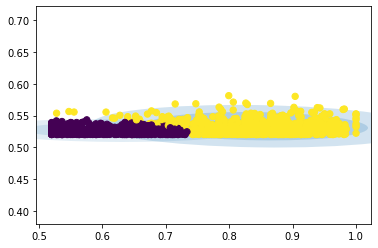

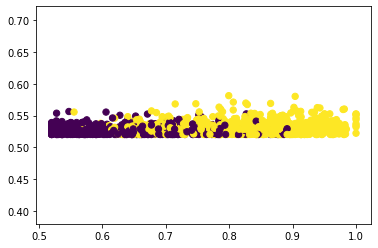

1
loss 0.6291164372390134
train_accuracy 0.8442367601246106
train_AUC 0.9242879154743562
linear -3.0562155337182575 2.711511792878085
valid_accuracy 0.7432432432432432
valid_AUC 0.8513409961685824
test_accuracy 0.8139013452914798
test_AUC 0.9069322254806126
2
loss 0.6241912151701291
train_accuracy 0.8608515057113187
train_AUC 0.9421087387189082
linear -1.0932058792373458 1.3244297156554146
valid_accuracy 0.7702702702702703
valid_AUC 0.8735632183908045
test_accuracy 0.8452914798206278
test_AUC 0.9363188334962528
3
loss 0.5930023775137685
train_accuracy 0.893042575285566
train_AUC 0.953695795729694
linear -0.9397193445344044 1.3106261016783198
valid_accuracy 0.8243243243243243
valid_AUC 0.9218390804597701
test_accuracy 0.8834080717488789
test_AUC 0.9559099055066796


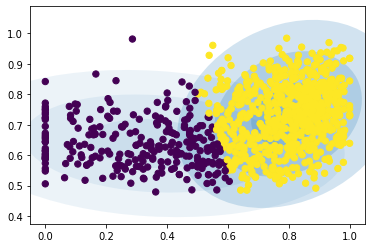

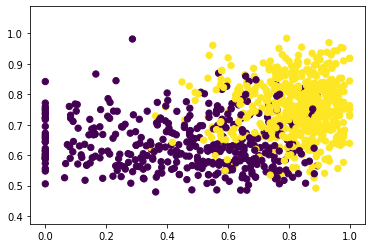

4
loss 0.5839164297542938
train_accuracy 0.9023883696780893
train_AUC 0.9668633061853401
linear -1.0528201643242852 1.4243696459691977
valid_accuracy 0.8243243243243243
valid_AUC 0.9455938697318007
test_accuracy 0.8968609865470852
test_AUC 0.9690860215053764
5
loss 0.5885942945971492
train_accuracy 0.9055036344755971
train_AUC 0.9708342504952675
linear -0.9922818682754962 1.3269256268845815
valid_accuracy 0.8648648648648649
valid_AUC 0.946360153256705
test_accuracy 0.9103139013452914
test_AUC 0.9753075105897686
6
loss 0.5729413916754384
train_accuracy 0.9138110072689511
train_AUC 0.9758837772397095
linear -0.9942998688091006 1.2992052886916283
valid_accuracy 0.8918918918918919
valid_AUC 0.9693486590038315
test_accuracy 0.9170403587443946
test_AUC 0.9758064516129032


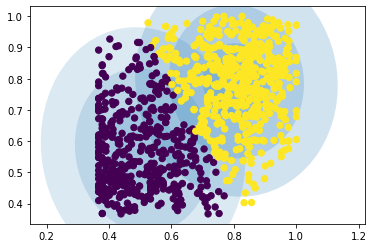

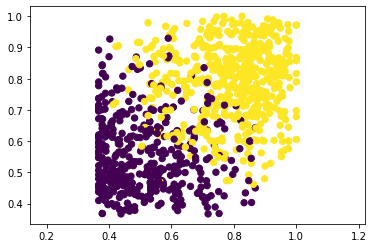

7
loss 0.5659055313345394
train_accuracy 0.9335410176531672
train_AUC 0.9808804754567466
linear -0.8408163215177379 1.172327740433362
valid_accuracy 0.9054054054054054
valid_AUC 0.9731800766283525
test_accuracy 0.9282511210762332
test_AUC 0.9804496578690126
8
loss 0.5622085725746682
train_accuracy 0.9293873312564901
train_AUC 0.9807395993836671
linear -0.8680337275396701 1.2417951144104349
valid_accuracy 0.9054054054054054
valid_AUC 0.9793103448275862
test_accuracy 0.9304932735426009
test_AUC 0.9809384164222873
9
loss 0.5736278736824453
train_accuracy 0.9283489096573209
train_AUC 0.9834514637904468
linear -0.8477667508181311 1.1776781948090813
valid_accuracy 0.918918918918919
valid_AUC 0.98544061302682
test_accuracy 0.92152466367713
test_AUC 0.9802867383512545


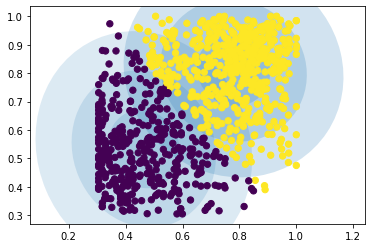

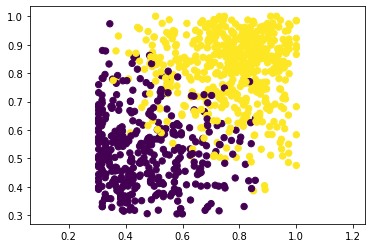

10
loss 0.5582870002823429
train_accuracy 0.9325025960539979
train_AUC 0.9852520360994937
linear -0.8403411122917036 1.2264677320228003
valid_accuracy 0.9324324324324325
valid_AUC 0.9915708812260535
test_accuracy 0.9327354260089686
test_AUC 0.9847670250896058
11
loss 0.5668515280461842
train_accuracy 0.9356178608515057
train_AUC 0.9836715826546335
linear -0.7782340795539736 1.2437630580868053
valid_accuracy 0.9324324324324325
valid_AUC 0.9877394636015325
test_accuracy 0.9304932735426009
test_AUC 0.9806634897360703
12
loss 0.5529496302013049
train_accuracy 0.9293873312564901
train_AUC 0.9848162007484041
linear -0.8480328288985161 1.2599714386728222
valid_accuracy 0.9324324324324325
valid_AUC 0.9915708812260537
test_accuracy 0.9237668161434978
test_AUC 0.9779244053437602


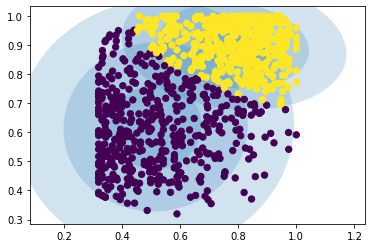

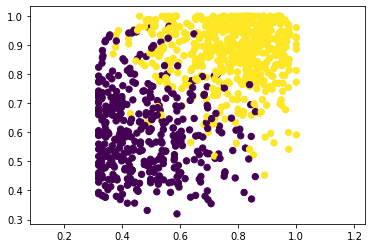

13
loss 0.5547045811317454
train_accuracy 0.9314641744548287
train_AUC 0.9842460928901606
linear -0.8238486323400005 1.301995691907101
valid_accuracy 0.9324324324324325
valid_AUC 0.9793103448275862
test_accuracy 0.9260089686098655
test_AUC 0.9807347670250897
14
loss 0.5642564633128937
train_accuracy 0.9356178608515057
train_AUC 0.9878890600924499
linear -0.7735120753900842 1.0927326433262265
valid_accuracy 0.9459459459459459
valid_AUC 0.9915708812260536
test_accuracy 0.9372197309417041
test_AUC 0.9864165852069078
15
loss 0.6015446736092352
train_accuracy 0.9241952232606438
train_AUC 0.9763108078362316
linear -0.7151966393323637 0.9343746586095709
valid_accuracy 0.8918918918918919
valid_AUC 0.9662835249042145
test_accuracy 0.8968609865470852
test_AUC 0.9713057999348322


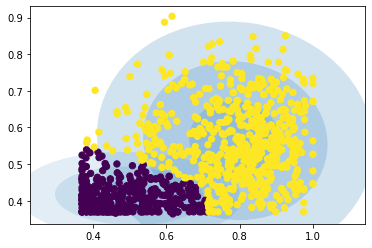

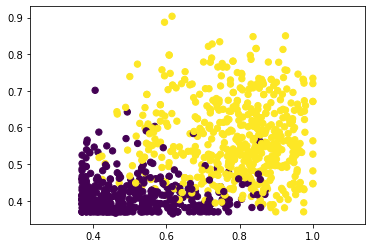

16
loss 0.603671649060214
train_accuracy 0.9418483904465212
train_AUC 0.9880475456746644
linear -0.7525762120298107 1.1786162805559837
valid_accuracy 0.9594594594594594
valid_AUC 0.9938697318007663
test_accuracy 0.9394618834080718
test_AUC 0.984461550993809
17
loss 0.7908271292497078
train_accuracy 0.9106957424714434
train_AUC 0.970068236847898
linear -0.7357024500179591 1.3468634160553121
valid_accuracy 0.8378378378378378
valid_AUC 0.9532567049808429
test_accuracy 0.8856502242152466
test_AUC 0.9588831867057673
18
loss 0.6124119806032444
train_accuracy 0.9262720664589823
train_AUC 0.9805899185560202
linear -0.7455474695887792 1.2989267141847836
valid_accuracy 0.9324324324324325
valid_AUC 0.9831417624521073
test_accuracy 0.9147982062780269
test_AUC 0.9728535353535352


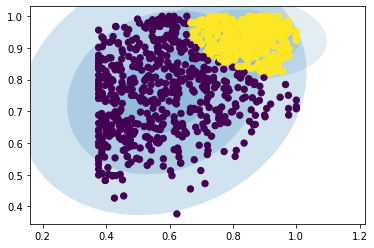

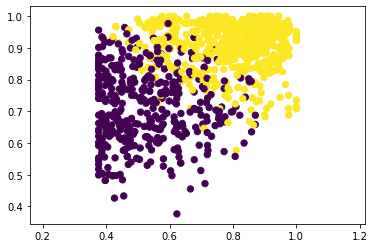

19
loss 0.7102510144761986
train_accuracy 0.9117341640706127
train_AUC 0.9727448822364076
linear -0.8062782102843004 1.4779486311760783
valid_accuracy 0.918918918918919
valid_AUC 0.9555555555555555
test_accuracy 0.8946188340807175
test_AUC 0.9671717171717171
20
loss 1.4789129465074855
train_accuracy 0.9158878504672897
train_AUC 0.9728615452344266
linear -0.7626271116744122 1.3099173099452592
valid_accuracy 0.8783783783783784
valid_AUC 0.9524904214559385
test_accuracy 0.9013452914798207
test_AUC 0.9687907298794396
21
loss 1.0629257379716421
train_accuracy 0.5711318795430945
train_AUC 0.9106185340083646
linear -0.6703527232212448 0.9322345157140227
valid_accuracy 0.6081081081081081
valid_AUC 0.9126436781609195
test_accuracy 0.5560538116591929
test_AUC 0.9301889866405995


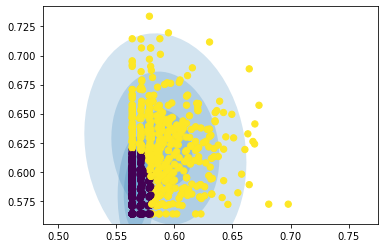

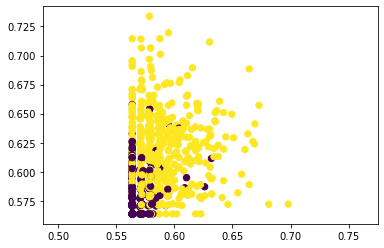

22
loss 0.7021171654388058
train_accuracy 0.833852544132918
train_AUC 0.908961038961039
linear -0.5246151108591376 0.877677036950691
valid_accuracy 0.7837837837837838
valid_AUC 0.9
test_accuracy 0.8452914798206278
test_AUC 0.9230103453893778
23
loss 2.6268489897773626
train_accuracy 0.9106957424714434
train_AUC 0.9716112700858464
linear -0.745916244320111 1.324441436586936
valid_accuracy 0.9054054054054054
valid_AUC 0.9586206896551723
test_accuracy 0.8923766816143498
test_AUC 0.968291788856305
24
loss 0.8213991637536986
train_accuracy 0.9158878504672897
train_AUC 0.977079022672243
linear -0.7125370890437254 1.1011911507450907
valid_accuracy 0.8783783783783784
valid_AUC 0.9325670498084291
test_accuracy 0.8946188340807175
test_AUC 0.9668662430759204


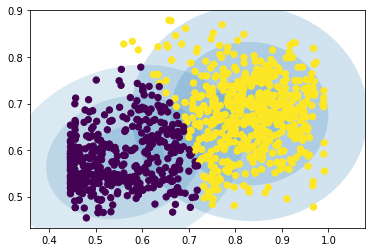

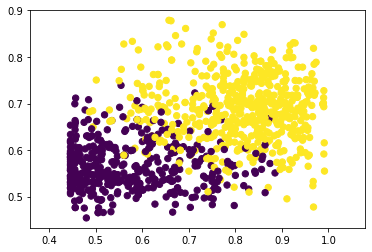

25
loss 1.0047121766404534
train_accuracy 0.9127725856697819
train_AUC 0.9736187541272288
linear -0.7186304400351855 1.1724663242221216
valid_accuracy 0.8783783783783784
valid_AUC 0.9379310344827587
test_accuracy 0.8968609865470852
test_AUC 0.9672633594004562
26
loss 0.8021464659125919
train_accuracy 0.9221183800623053
train_AUC 0.9794981289896544
linear -0.7533308709888415 1.1607578011537962
valid_accuracy 0.8918918918918919
valid_AUC 0.9532567049808429
test_accuracy 0.9013452914798207
test_AUC 0.9728637178233952
27
loss 0.6447795894567178
train_accuracy 0.9221183800623053
train_AUC 0.9815100154083205
linear -0.7192652618590792 1.1603696921807658
valid_accuracy 0.8378378378378378
valid_AUC 0.9586206896551723
test_accuracy 0.905829596412556
test_AUC 0.9736681329423266


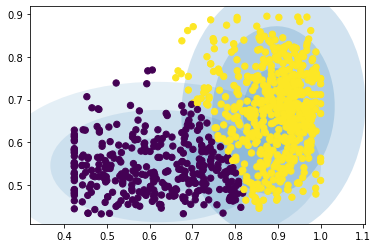

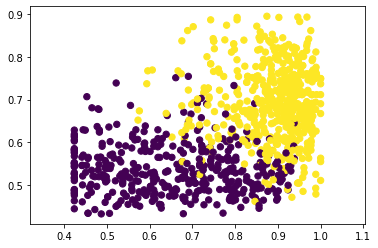

28
loss 12.688850687898379
train_accuracy 0.5711318795430945
train_AUC 0.5
linear nan -inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


valid_accuracy 0.6081081081081081
valid_AUC 0.5
test_accuracy 0.5560538116591929
test_AUC 0.5
29
loss 18.657218687301622
train_accuracy 0.5711318795430945
train_AUC 0.5
linear nan -inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


valid_accuracy 0.6081081081081081
valid_AUC 0.5
test_accuracy 0.5560538116591929
test_AUC 0.5
30
loss 18.50615568100321
train_accuracy 0.5711318795430945
train_AUC 0.5
linear nan -inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


valid_accuracy 0.6081081081081081
valid_AUC 0.5
test_accuracy 0.5560538116591929
test_AUC 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:146: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


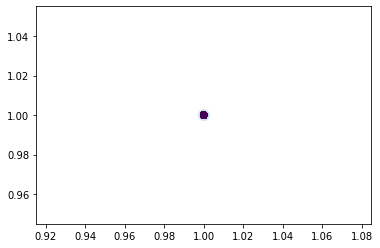

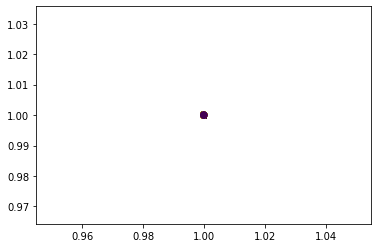

In [39]:
#run
num_epochs = 31

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.BCELoss()
train_score=[]
valid_score=[]
test_score=[]


for epoch in range(num_epochs):
    print(epoch)
    loss = train()
    print("loss", loss)
    train_accuracy, train_AUC, valid_accuracy, valid_AUC, test_accuracy, test_AUC = check_with_SVM()
    train_score.append([train_accuracy, train_AUC])
    valid_score.append([valid_accuracy, valid_AUC])
    test_score.append([test_accuracy, test_AUC])
    if epoch % 3 == 0:
        torch.save(model.state_dict(), 'GNN_model_' + str(epoch) + '.pkl')
        this_pred, this_labels = evaluate(AGG_Dataset_train)
        gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=42)
        plt.subplots()
        plot_gmm(gmm, this_pred)
        plt.subplots()
        plot_real(this_pred, this_labels)
        plt.show()


[16 14]


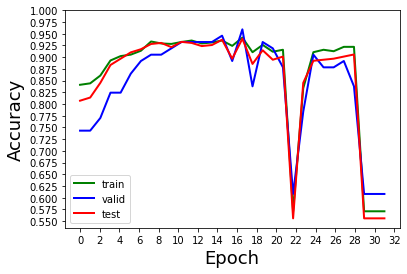

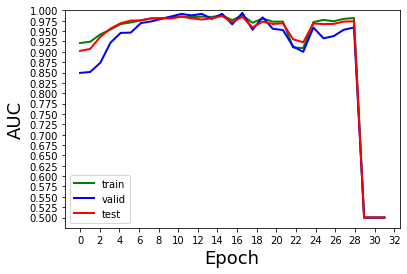

In [40]:
from matplotlib.pyplot import MultipleLocator

epoch_l = np.linspace(0, 31, 31)
x_majot_locator=MultipleLocator(2)
y_majot_locator=MultipleLocator(0.025)

font = {
        'size': 18,
        }

plt.subplots()
### accuracy
plt.plot(epoch_l, np.array(train_score)[:,0], 'g-', linewidth=2, markersize=12, label='train')
plt.plot(epoch_l, np.array(valid_score)[:,0], 'b-', linewidth=2, markersize=12, label='valid')
plt.plot(epoch_l, np.array(test_score)[:,0], 'r-', linewidth=2, markersize=12, label='test')
print(np.argmax(test_score, axis=0))
ax=plt.gca()
ax.xaxis.set_major_locator(x_majot_locator)
ax.yaxis.set_major_locator(y_majot_locator)
plt.ylim(top=1)
plt.ylabel("Accuracy", fontdict=font)
plt.xlabel("Epoch", fontdict=font)
plt.legend()
plt.show()

plt.subplots()
### auc
plt.plot(epoch_l, np.array(train_score)[:,1], 'g-', linewidth=2, markersize=12, label='train')
plt.plot(epoch_l, np.array(valid_score)[:,1], 'b-', linewidth=2, markersize=12, label='valid')
plt.plot(epoch_l, np.array(test_score)[:,1], 'r-', linewidth=2, markersize=12, label='test')
ax=plt.gca()
ax.xaxis.set_major_locator(x_majot_locator)
ax.yaxis.set_major_locator(y_majot_locator)
plt.ylim(top=1)
plt.ylabel("AUC", fontdict=font)
plt.xlabel("Epoch", fontdict=font)
plt.legend()
plt.show()



In [ ]:
from google.colab import files

files.download('tensor/GNN_model_24.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

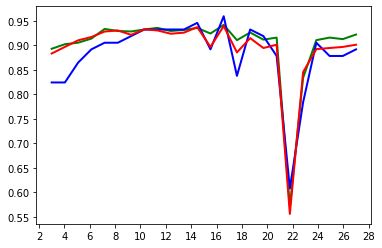

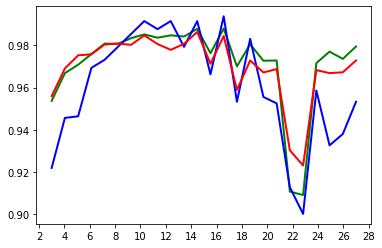

In [41]:
from matplotlib.pyplot import MultipleLocator

min_epoch = 3
max_epoch = 27
epoch_l = np.linspace(min_epoch, max_epoch, 24)
x_majot_locator=MultipleLocator(2)

plt.subplots()
### accuracy
plt.plot(epoch_l, np.array(train_score)[min_epoch:max_epoch,0], 'g-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(valid_score)[min_epoch:max_epoch,0], 'b-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(test_score)[min_epoch:max_epoch,0], 'r-', linewidth=2, markersize=12)
ax=plt.gca()
ax.xaxis.set_major_locator(x_majot_locator)
plt.show()

plt.subplots()
### auc
plt.plot(epoch_l, np.array(train_score)[min_epoch:max_epoch,1], 'g-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(valid_score)[min_epoch:max_epoch,1], 'b-', linewidth=2, markersize=12)
plt.plot(epoch_l, np.array(test_score)[min_epoch:max_epoch,1], 'r-', linewidth=2, markersize=12)
ax=plt.gca()
ax.xaxis.set_major_locator(x_majot_locator)
plt.show()